## Import

In [ ]:
from gemseo import generate_coupling_graph
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo.algos.design_space import DesignSpace
from gemseo.algos.parameter_space import ParameterSpace
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

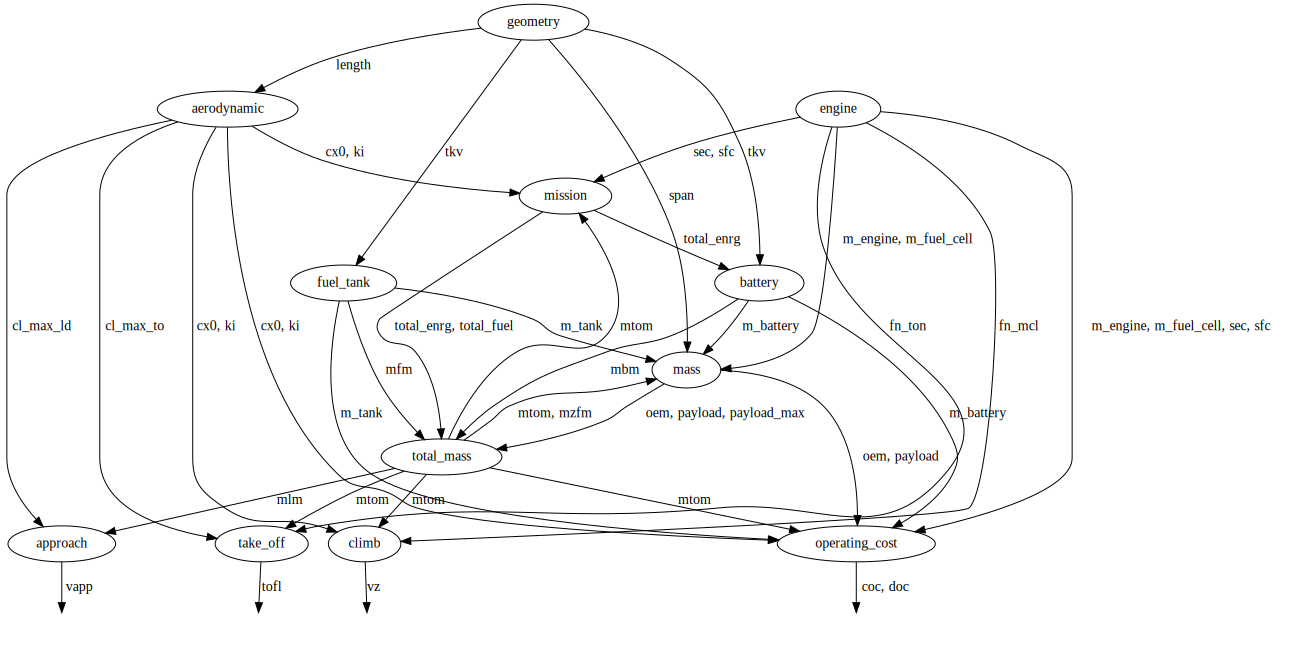

In [4]:
generate_coupling_graph(disciplines)

## Design Space

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [ ]:
from gemseo.algos.parameter_space import ParameterSpace
design_space = DesignSpace()
design_space.add_variable("slst", lower_bound=convert_from("kN", 100), upper_bound=convert_from("kN", 200), value=convert_from("kN", 150))
design_space.add_variable("n_pax", lower_bound=120, upper_bound=180, value=150)
design_space.add_variable("area", lower_bound=convert_from("m2", 100), upper_bound=convert_from("m2", 200), value=convert_from("m2", 180))
design_space.add_variable("ar", lower_bound=5, upper_bound=20, value=9)


uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

## Scenario

In [ ]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    "Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(n_samples=20)#TaylorPolynomial_Settings()#Sampling_Settings(n_samples=20),
)

In [ ]:
scenario.add_constraint("tofl", "Margin", factor=3.0,constraint_type="ineq", positive=False, value=1900.)
scenario.add_constraint("vapp","Margin", factor=3.0, constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario.add_constraint("vz", "Margin", factor=3.0,constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario.add_constraint("span", "Margin", factor=3.0, constraint_type="ineq", positive=False, value=40.0)
scenario.add_constraint("length", "Margin", factor=3.0,constraint_type="ineq", positive=False, value=45.0)
scenario.add_constraint("fm", "Margin", factor=3.0,constraint_type="ineq", positive=True, value=0.0)



In [ ]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 14:47:18: *** Start MDOScenario execution ***
    INFO - 14:47:18: MDOScenario
    INFO - 14:47:18:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:47:18:    MDO formulation: MDF
    INFO - 14:47:18: Optimization problem:
    INFO - 14:47:18:    minimize mtom(slst, n_pax, area, ar, gi, vi, aef, cef, sef)
    INFO - 14:47:18:    with respect to aef, ar, area, cef, gi, n_pax, sef, slst, vi
    INFO - 14:47:18:    subject to constraints:
    INFO - 14:47:18:       tofl(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 1900.0
    INFO - 14:47:18:       vapp(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 69.44999999400001
    INFO - 14:47:18:       vz(slst, n_pax, area, ar, gi, vi, aef, cef, sef) >= 1.524
    INFO - 14:47:18:       span(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 40.0
    INFO - 14:47:18:       length(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 45.0
    INFO - 14

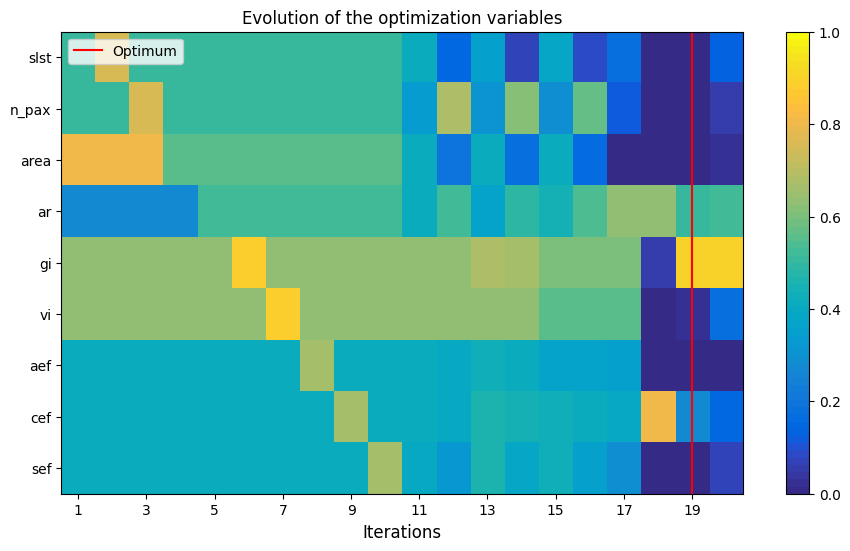

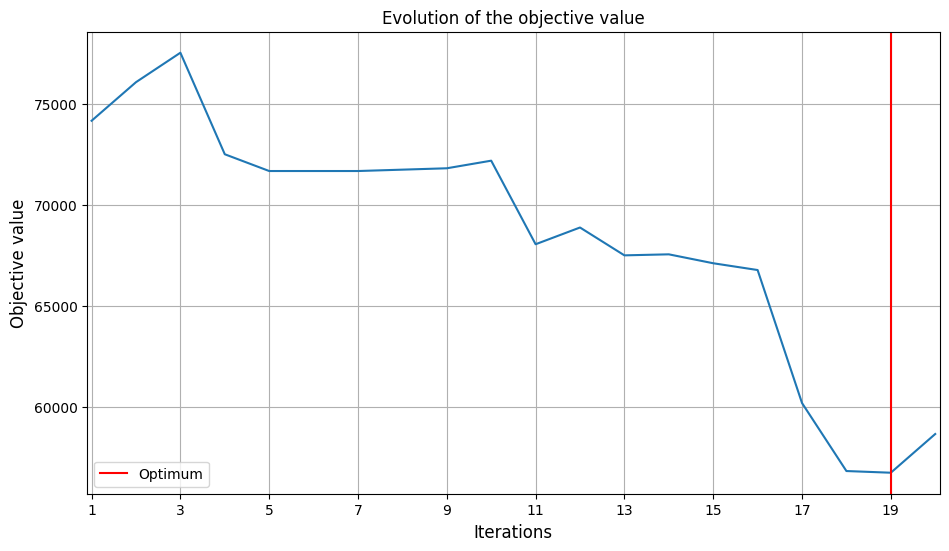

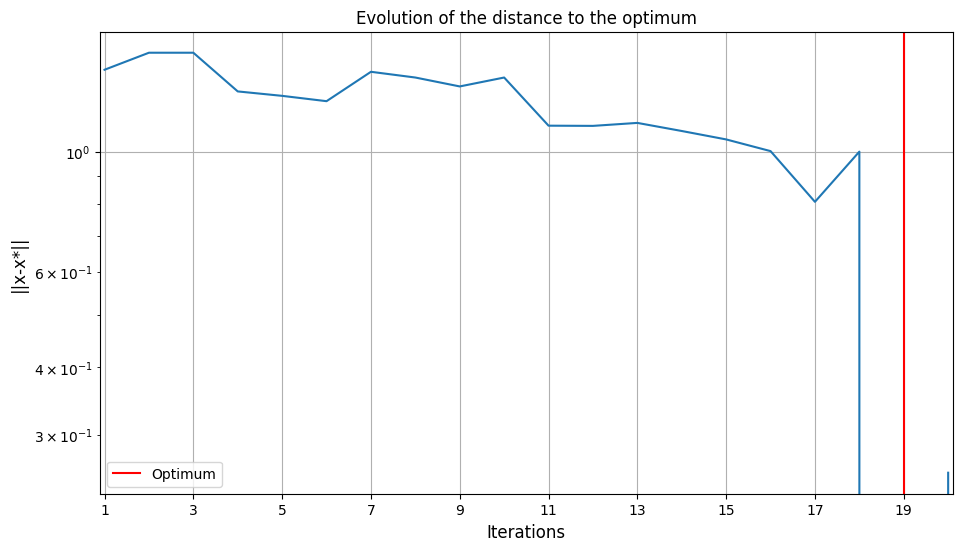

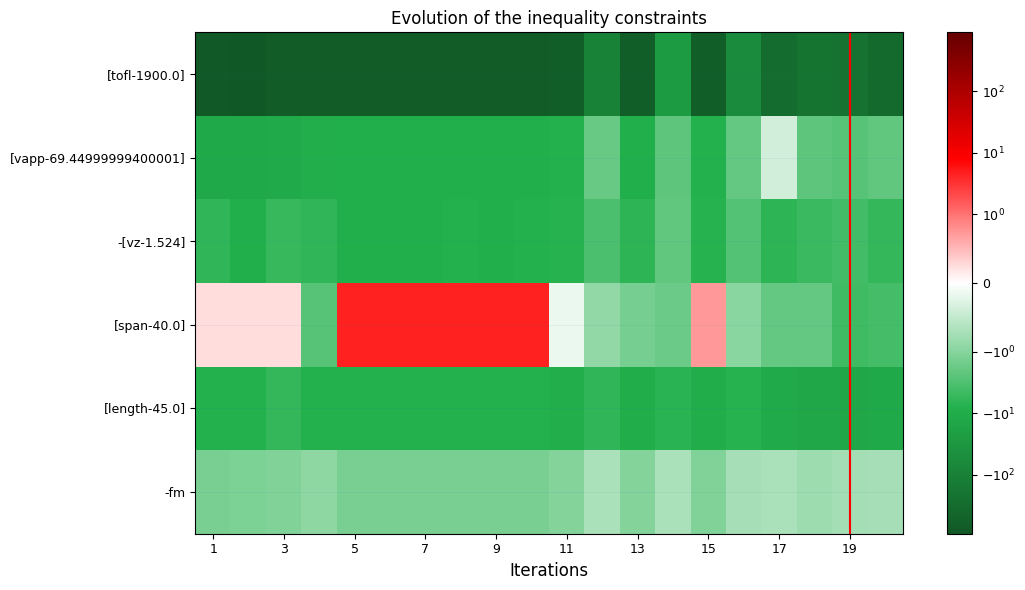

In [10]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)


# Visualisation de l'avion final

In [ ]:
from gemseo_oad_training.utils import draw_aircraft
dict_result = scenario.optimization_result.x_opt_as_dict
draw_aircraft(area=dict_result["area"][0],slst=dict_result["slst"][0], n_pax=dict_result["n_pax"][0], title="Résultat final")

ImportError: cannot import name 'draw_aircraft' from 'gemseo_oad_training.utils' (/home/n7student/2A/lh2pac/.venv/lib/python3.10/site-packages/gemseo_oad_training/utils.py)